In [ ]:
import os

import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import ascii

from scipy import ndimage

import numpy as np

<div class="alert alert-block alert-info"> <b>NOTE</b> This is a jupyter notebook for selecting LSBG candidates </div>

Definition of LSBG

- Freeman 1970: 
    - central surface brightness - $\mu_{B, 0}$ > 22.7 mag $arcsec^{-2}$ 
- McGaugh et al. 2001    
    - central maximum stellar surface densities - $\Sigma_{*, 0}$ < 100 $M_{\odot}$ $pc^{-2}$

Things to check

- redshift range
- volume limited (preferred) vs. magnitude limited
- surface brightness distribution as a function of redshift
- comepleteness?
- How to convert sdss filter sets into UBVRI
- inclination

magnitude conversion
- https://arxiv.org/pdf/1007.4014.pdf
- https://arxiv.org/pdf/1811.04569.pdf
- Kim & Lee 2013, How Does the Surface Density and Size of Disk Galaxies Measured in Hydrodynamic Simulations Correlate with the Halo SpinParameter?

### bulge
- Sersic profile: ***Photo-Bulge***
    - $\Sigma(r) = \Sigma_{e}\exp{(-k((\frac{r}{r_{e}})^{\frac{1}{n}} - 1))}$, surface brightness at radius r
    - $k = 1.9992n - 0.3271$
    
- de Vaucoulers profile:
    - $n = 4$ 
    - bulge of late-type spiral (n = 1), bright ellipticals / bulge of early-type spiral (n = 4)
    
### disk
- exponential profile: ***Photo-Disk***
    - $\Sigma(r) = \Sigma_{0}\exp{(-\frac{r}{r_{d}})}$
    - $\Sigma_{0} = central surface brightness$, $r_{d} = disc scale length$

- Simard+02, GIM2D
    - THE DEEP GROTH STRIP SURVEY. II. HUBBLE SPACE TELESCOPE STRUCTURAL PARAMETERS OF GALAXIES IN THE GROTH STRIP
    
- Simard+11, disc+bulge decomposition
    - A CATALOG OF BULGE+DISK DECOMPOSITIONS AND UPDATED PHOTOMETRY FOR 1.12 MILLION GALAXIES IN THE SLOAN DIGITAL SKY SURVEY
    
- Bottrell+19, Stripe82
    - Bulge plus disc and S¢¥ersic decomposition catalogues for 16,908 galaxies in the SDSS Stripe 82 co-adds: A detailed study of the ugriz structural measurements
 

# Galaxy catalog: Bottrell+19

- (ps) single-component Sersic profile
- (n4) two-component nb = 4 bulge and exponential disc
- (fn) two-component free-nb bulge and exponential disc

In [2]:
# zeropoint = 30
#  -2.5 * np.log10(tbl_ps['f_g'][:10])+ 30 = tbl_ps['g2dmag_g'][:10]

In [3]:
from utils.decomposition import bulge, disk

In [4]:
path = './bottrell/stz855_supplemental_files/Stripe82_DeepMorphologies_TXT/'

tbl_n4 = ascii.read(path + 'sdss_s82_morph_gr_n4.txt')


In [5]:
#arcsec
radii = np.arange(0.01, 20, 0.01) 

In [6]:
# calculate surface-brightness at r = 0
mu0_n4 = []

for idx in range(len(tbl_n4)):
    # bulge to total ratio
    btt = tbl_n4['bt_r'][idx]

    #flux per area
    flux_bulge_arb = bulge(r = radii, Sig_e = 10, r_e = tbl_n4['re'][idx], n = tbl_n4['n'][idx])
    flux_disk_arb = disk(r = radii, Sig_0 = 10, r_d = tbl_n4['rd'][idx])
    flux_disk_arb *= sum(flux_bulge_arb)/sum(flux_disk_arb) * (1 - btt) / btt

    petro_r50 = tbl_n4['petroR50_g'][idx]
    petro_r50_idx = int(petro_r50 // 0.01)

    #flux within r50 to SB
    flux_bulge_arb_r50 = flux_bulge_arb[:petro_r50_idx]
    flux_disk_arb_r50 = flux_disk_arb[:petro_r50_idx]
    flux_total_arb_r50 = flux_bulge_arb_r50 + flux_disk_arb_r50

    flux_avg_r50 = [flux_total_arb_r50[ii] * 2 * np.pi * 0.01**2 * (ii+1) for ii in range(len(flux_total_arb_r50))] 
    flux_avg_r50 = np.sum(flux_avg_r50) / (np.pi * petro_r50**2)

    # SB in R50 catalog / smae derived
    factor = 10**((tbl_n4['mu50_g'][idx] - 30) / -2.5) / flux_avg_r50
    flux_bulge_corr = flux_bulge_arb * factor * btt
    flux_disk_corr = flux_disk_arb * factor * (1 - btt)
    flux_total = flux_bulge_corr + flux_disk_corr
    # flux_corr = 10**((sb_arb - 30) / -2.5) * factor
    sb_bulge_corr = -2.5 * np.log10(flux_bulge_corr) + 30
    sb_disk_corr = -2.5 * np.log10(flux_disk_corr) + 30
    sb_total = -2.5 * np.log10(flux_total) + 30
    
    mu0 = sb_disk_corr[0]
    mu0_n4.append(mu0)

mu0_n4 = np.array(mu0_n4)

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/home/ehko/lsbg_env/utils/decomposition.py:6: RuntimeWarning: divide by zero encountered in true_divide
  func = Sig_e * np.exp(-k * ( (r/r_e)**(1/n) - 1 ))
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply
/

In [7]:
mu0_n4 = []
for idx in range(len(tbl_n4)):
    # bulge to total ratio
    btt = tbl_n4['bt_r'][idx]

    #flux per area
    flux_bulge_arb = bulge(r = radii, Sig_e = 10, r_e = tbl_n4['re'][idx], n = tbl_n4['n'][idx])
    flux_disk_arb = disk(r = radii, Sig_0 = 10, r_d = tbl_n4['rd'][idx])
    flux_disk_arb *= sum(flux_bulge_arb)/sum(flux_disk_arb) * (1 - btt) / btt

    petro_r50 = tbl_n4['petroR50_g'][idx]
    petro_r50_idx = int(petro_r50 // 0.01)

    #flux within r50 to SB
    flux_bulge_arb_r50 = flux_bulge_arb[:petro_r50_idx]
    flux_disk_arb_r50 = flux_disk_arb[:petro_r50_idx]
    flux_total_arb_r50 = flux_bulge_arb_r50 + flux_disk_arb_r50

    flux_avg_r50 = [flux_total_arb_r50[ii] * 2 * np.pi * 0.01**2 * (ii+1) for ii in range(len(flux_total_arb_r50))] 
    flux_avg_r50 = np.sum(flux_avg_r50) / (np.pi * petro_r50**2)

    # SB in R50 catalog / smae derived
    factor = 10**((tbl_n4['mu50_g'][idx] - 30) / -2.5) / flux_avg_r50
    flux_bulge_corr = flux_bulge_arb * factor * btt
    flux_disk_corr = flux_disk_arb * factor * (1 - btt)
    flux_total = flux_bulge_corr + flux_disk_corr
    # flux_corr = 10**((sb_arb - 30) / -2.5) * factor
    sb_bulge_corr = -2.5 * np.log10(flux_bulge_corr) + 30
    sb_disk_corr = -2.5 * np.log10(flux_disk_corr) + 30
    sb_total = -2.5 * np.log10(flux_total) + 30
    
    mu0 = sb_disk_corr[0]
    mu0_n4.append(mu0)

mu0_n4 = np.array(mu0_n4)

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/home/ehko/anaconda3/lib/python

(array([2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 4.000e+00,
        2.100e+01, 9.800e+01, 3.940e+02, 9.340e+02, 1.839e+03, 2.580e+03,
        2.341e+03, 1.796e+03, 1.406e+03, 1.172e+03, 8.250e+02, 5.640e+02,
        3.330e+02]),
 array([16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. ,
        21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5]),
 <BarContainer object of 19 artists>)

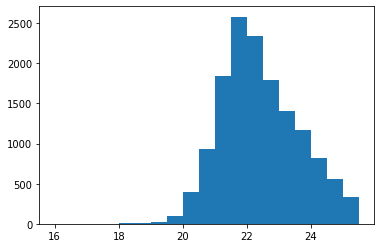

In [8]:
plt.hist(mu0_n4, bins = np.arange(16, 26, 0.5))

In [15]:
z_mask = (tbl_n4['z'] > 0.015) & (tbl_n4['z'] < 0.055)
# sf_mask1 = tbl_fn['mu50_g'] > 23
# sf_mask2 = mu0_fn > 23
# sf_mask = sf_mask1 & sf_mask2
sf_mask = mu0_n4 > 23
inc_mask = (tbl_n4['incd'] <= 75) & (tbl_n4['incd'] >= 25)
sersic_mask = 

lsb_mask = sf_mask & inc_mask & z_mask
hsb_mask = ~sf_mask & inc_mask & z_mask

sum(lsb_mask), sum(hsb_mask)

(330, 2165)

Text(0, 0.5, 'count')

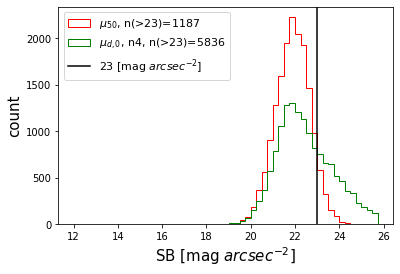

In [18]:
fig, ax = plt.subplots()
mu50num = sum(tbl_n4['mu50_g'] > 23)

ax.hist(tbl_n4['mu50_g'], bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', color = 'red', label = '$\mu_{50}$'+ f', n(>23)={mu50num}')
# ax.hist(mu0_n4, bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', color = 'royalblue', label = '$\mu_{d, 0}$, ps' + f', n(>23)={sum(mu0_ps > 23)}')
ax.hist(mu0_n4, bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', color = 'green', label = '$\mu_{d, 0}$, n4' + f', n(>23)={sum(mu0_n4 > 23)}')
# ax.hist(mu0_n4, bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', color = 'orange', label = '$\mu_{d, 0}$, fn' + f', n(>23)={sum(mu0_fn > 23)}')

ax.axvline(23, color = 'black', label = '23 [mag $arcsec^{-2}$]')

ax.legend(fontsize = 11, loc = 'upper left')

ax.set_xlabel(r'SB [mag $arcsec^{-2}$]', fontsize = 15)
ax.set_ylabel('count', fontsize = 15)

# fig.savefig('./figs/hist.png')

Text(0.5, 0, '$\\mu_{0, d}$ [mag/$arcsec^{2}$]')

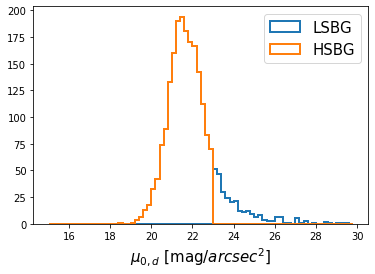

In [19]:
plt.hist(mu0_n4[lsb_mask], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG')
plt.hist(mu0_n4[hsb_mask], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG')

plt.legend(fontsize = 15)
plt.xlabel('$\mu_{0, d}$ [mag/$arcsec^{2}$]', fontsize = 15)

# plt.savefig('./figs/mu_dist.png')

Text(0.5, 0, '$\\mu_{50, g}$ [mag/$arcsec^{2}$]')

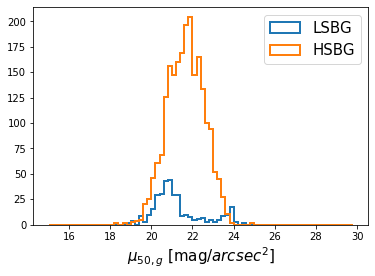

In [20]:
plt.hist(tbl_n4[lsb_mask]['mu50_g'], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG')
plt.hist(tbl_n4[hsb_mask]['mu50_g'], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG')

plt.legend(fontsize = 15)
plt.xlabel('$\mu_{50, g}$ [mag/$arcsec^{2}$]', fontsize = 15)
# plt.savefig('./figs/mu50_dist.png')

Text(0.5, 0, 'redshift')

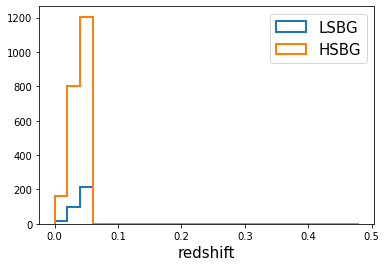

In [21]:
plt.hist(tbl_n4[lsb_mask]['z'], bins = np.arange(0, 0.5, 0.02), histtype = 'step', linewidth = 2, label = 'LSBG')
plt.hist(tbl_n4[hsb_mask]['z'], bins = np.arange(0, 0.5, 0.02), histtype = 'step', linewidth = 2, label = 'HSBG')

plt.legend(fontsize = 15)
plt.xlabel('redshift', fontsize = 15)

Text(0.5, 0, 'bulge-to-total fraction')

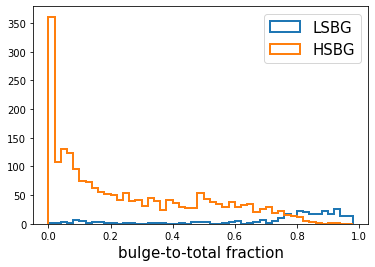

In [22]:
plt.hist(tbl_n4[lsb_mask]['bt_r'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'LSBG')
plt.hist(tbl_n4[hsb_mask]['bt_r'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'HSBG')

plt.legend(fontsize = 15)
plt.xlabel('bulge-to-total fraction', fontsize = 15)

# plt.savefig('./figs/btr_dist.png')

Text(0.5, 0, 'sersic index')

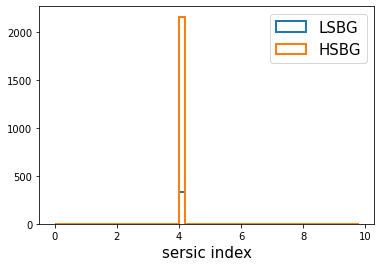

In [23]:
plt.hist(tbl_n4[lsb_mask]['n'], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG')
plt.hist(tbl_n4[hsb_mask]['n'], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG')

plt.legend(fontsize = 15)
plt.xlabel('sersic index', fontsize = 15)

# plt.savefig('./figs/sersic_dist.png')

In [ ]:
rd_kpc = [float(x) if x != 'NULL' else np.nan for x in tbl_fn['rd_kpc']]
rd_kpc = np.array(rd_kpc)

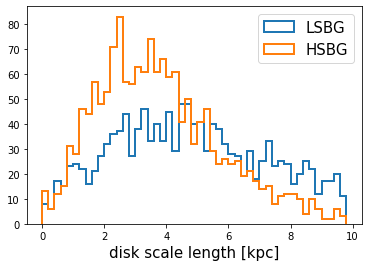

In [ ]:
plt.hist(rd_kpc[lsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG')
plt.hist(rd_kpc[hsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG')

plt.legend(fontsize = 15)
plt.xlabel('disk scale length [kpc]', fontsize = 15)

plt.savefig('./figs/rd_dist.png')

In [ ]:
re_kpc = [float(x) if x != 'NULL' else np.nan for x in tbl_fn['re_kpc']]
re_kpc = np.array(re_kpc)

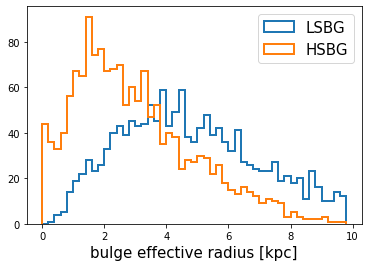

In [ ]:
plt.hist(re_kpc[lsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG')
plt.hist(re_kpc[hsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG')

plt.legend(fontsize = 15)
plt.xlabel('bulge effective radius [kpc]', fontsize = 15)

plt.savefig('./figs/re_dist.png')

(array([ 24.,  45.,  54.,  56.,  84.,  92., 103.,  87., 100., 110.,  88.,
         92.,  67.,  54.,  70.,  60.,  50.,  45.,  43.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <BarContainer object of 19 artists>)

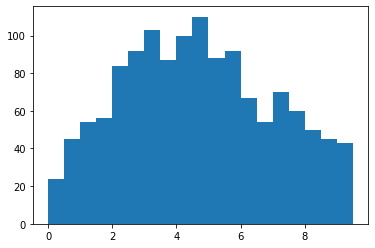

In [ ]:
plt.hist(rd_kpc, bins = np.arange(0, 10, 0.5))

In [ ]:
np.any(tbl_fn[tot_mask]['rd_kpc'] == 'NULL')

True

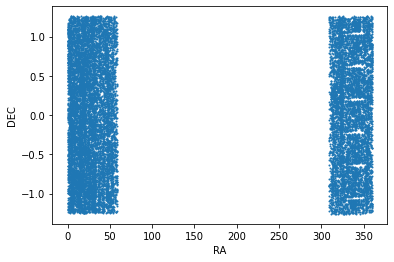

In [ ]:
plt.scatter(tbl['ra'], tbl['decl'], s = 1)

plt.xlabel('RA')
plt.ylabel('DEC')

plt.savefig('./figs/target_distribution.png')

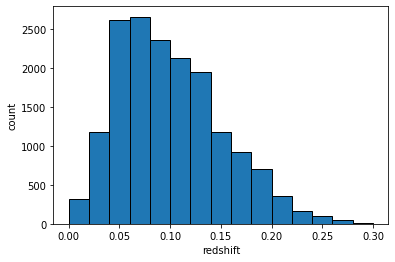

In [ ]:
plt.hist(tbl[tbl['z'] > 0]['z'], bins  = np.arange(0, 0.32, 0.02), edgecolor = 'black')

plt.xlabel('redshift')
plt.ylabel('count')

plt.savefig('./figs/z_distribution.png')

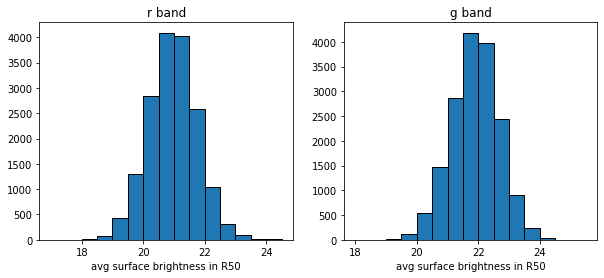

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].hist(np.array(tbl['mu50_r']), edgecolor = 'black', bins = np.arange(17, 25, 0.5))
ax[0].set_xlabel('avg surface brightness in R50')
ax[0].set_title('r band')

ax[1].hist(np.array(tbl['mu50_g']), edgecolor = 'black', bins = np.arange(18, 26, 0.5))
ax[1].set_xlabel('avg surface brightness in R50')
ax[1].set_title('g band')

fig.savefig('./figs/mu50_distribution.png')

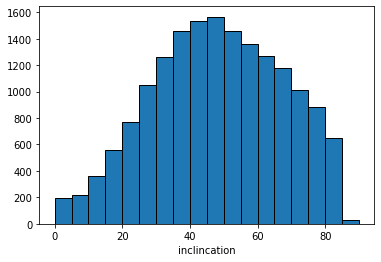

In [ ]:
plt.hist(tbl['incd'], edgecolor = 'black', bins = np.arange(0, 95, 5))

plt.xlabel('inclincation')

plt.savefig('./figs/incd_distribution.png')

In [ ]:
mask_incl = tbl['incd'] < 30
mask_mu = tbl['mu50_g'] > 23

In [ ]:
sum(mask_incl & mask_mu), sum(mask_incl), sum(mask_mu)

(241, 3151, 1188)

In [ ]:
tbl.keys()

['objID',
 'dr7_objID',
 'ra',
 'decl',
 'run',
 'rerun',
 'camcol',
 'field',
 'ID',
 'petroMag_r',
 'extinction_r',
 'z',
 'sciim_nx',
 'sciim_ny',
 'prchost',
 'start_time',
 'end_time',
 'dfm_r',
 'f_r',
 'dfp_r',
 'dg2dmagm_r',
 'g2dmag_r',
 'dg2dmagp_r',
 'dbtm_r',
 'bt_r',
 'dbtp_r',
 'drem',
 're',
 'drep',
 'dem',
 'e',
 'dep',
 'dphibm',
 'phib',
 'dphibp',
 'drdm',
 'rd',
 'drdp',
 'didm',
 'incd',
 'didp',
 'dphidm',
 'phid',
 'dphidp',
 'ddxm_g',
 'dx_g',
 'ddxp_g',
 'ddym_g',
 'dy_g',
 'ddyp_g',
 'ddbm_r',
 'db_r',
 'ddbp_r',
 'dnm',
 'n',
 'dnp',
 'rhalf_r',
 'rchi2_r',
 'c1_r',
 'c2_r',
 'c3_r',
 'c4_r',
 'a_r',
 'da_r',
 'az2_1_r',
 'az2_2_r',
 'az3_1_r',
 'az3_2_r',
 'az5_1_r',
 'az5_2_r',
 'dz_r',
 'rt1_1_r',
 'rt1_2_r',
 'rt1_3_r',
 'ra1_1_r',
 'ra1_2_r',
 'ra1_3_r',
 'prcflag',
 'rd_kpc',
 're_kpc',
 'rhalf_kpc_r',
 'petroR50_r',
 'mu50_r',
 'Vmax',
 'Mr_galaxy',
 'Mr_bulge',
 'Mr_disk',
 'Mg_galaxy',
 'Mg_bulge',
 'Mg_disk',
 'extinction_g',
 'petroMag_g',
 'dfm_g

B = g + 0.47(g-r) + 0.17

$\mu_{0}(m) = m + 2.5\log{(2\pi a^{2})} + 2.5\log{(b/a)} - 10\log{(1+z)}$

In [ ]:
B_conv = tbl_fn['g2dmag_g'] + 0.47 * (tbl_fn['g2dmag_g'] - tbl_fn['g2dmag_r']) + 0.17

In [ ]:
a = tbl_fn['rhalf_r']

In [ ]:
bovera = np.arccos(tbl_fn['incd'] * np.pi / 180)

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


In [ ]:
muB_conv = B_conv + 2.5 * np.log10(2 * np.pi * a**2) + 2.5 * np.log10(bovera) - 10 * np.log10(1 + tbl_fn['z'])

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


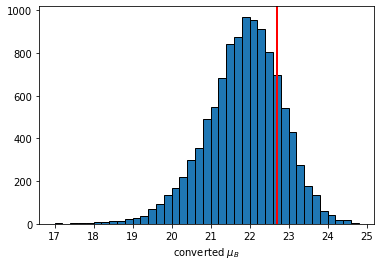

In [ ]:
plt.hist(muB_conv, bins = np.arange(17, 25, 0.2), edgecolor = 'black')

plt.axvline(22.7, color = 'red', linewidth = 2)

plt.xlabel('converted $\mu_{B}$')
plt.savefig('./figs/converted_muB.png')

In [ ]:
sum(muB_conv > 22.5)

2795

In [ ]:
lsbconv_mask = (muB_conv > 22.5) & inc_mask
hsbconv_mask = (muB_conv < 22.5) & inc_mask

In [ ]:
sum(lsb_mask), sum(lsbconv_mask)

(1543, 1207)

In [ ]:
sum(lsbconv_mask), sum(hsbconv_mask)

(1207, 1925)

In [ ]:
# lsbconv_mask vs. hsbconv_mask

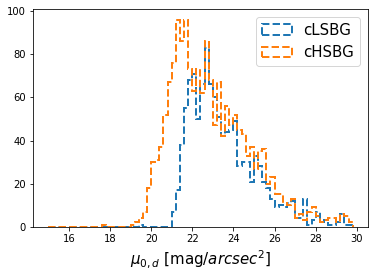

In [ ]:
plt.hist(mu0_fn[lsbconv_mask], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG', linestyle = '--')
plt.hist(mu0_fn[hsbconv_mask], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'cHSBG', linestyle = '--')

plt.legend(fontsize = 15)
plt.xlabel('$\mu_{0, d}$ [mag/$arcsec^{2}$]', fontsize = 15)

plt.savefig('./figs/mu_distc.png')

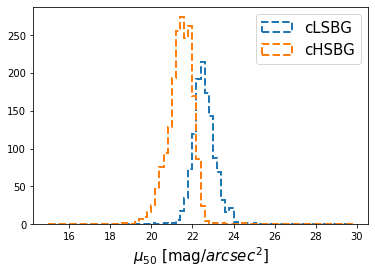

In [ ]:
plt.hist(tbl_fn[lsbconv_mask]['mu50_g'], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG', linestyle = '--')
plt.hist(tbl_fn[hsbconv_mask]['mu50_g'], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'cHSBG', linestyle = '--')

plt.legend(fontsize = 15)
plt.xlabel('$\mu_{50}$ [mag/$arcsec^{2}$]', fontsize = 15)

plt.savefig('./figs/mu50_distc.png')

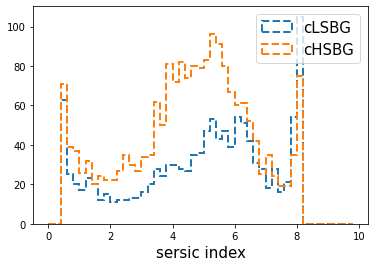

In [ ]:
plt.hist(tbl_fn[lsbconv_mask]['n'], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG', linestyle = '--')
plt.hist(tbl_fn[hsbconv_mask]['n'], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cHSBG', linestyle = '--')

plt.legend(fontsize = 15)
plt.xlabel('sersic index', fontsize = 15)

plt.savefig('./figs/sersic_distc.png')

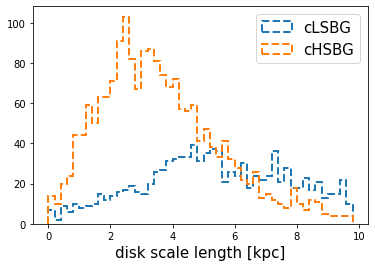

In [ ]:
plt.hist(rd_kpc[lsbconv_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG', linestyle = '--')
plt.hist(rd_kpc[hsbconv_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cHSBG', linestyle = '--')

plt.legend(fontsize = 15)
plt.xlabel('disk scale length [kpc]', fontsize = 15)

plt.savefig('./figs/dr_distc.png')

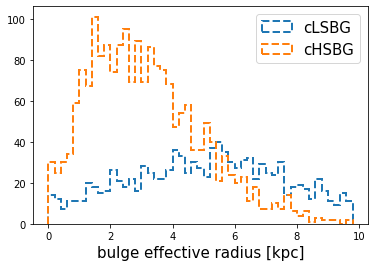

In [ ]:
plt.hist(re_kpc[lsbconv_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG', linestyle = '--')
plt.hist(re_kpc[hsbconv_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cHSBG', linestyle = '--')

plt.legend(fontsize = 15)
plt.xlabel('bulge effective radius [kpc]', fontsize = 15)

plt.savefig('./figs/re_distc.png')

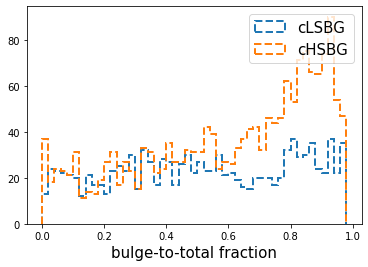

In [ ]:
plt.hist(tbl_fn[lsbconv_mask]['bt_r'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'cLSBG', linestyle = '--')
plt.hist(tbl_fn[hsbconv_mask]['bt_r'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'cHSBG', linestyle = '--')

plt.legend(fontsize = 15)
plt.xlabel('bulge-to-total fraction', fontsize = 15)

plt.savefig('./figs/btr_distc.png')

In [ ]:
# lsbconv_mask vs. lsb_mask


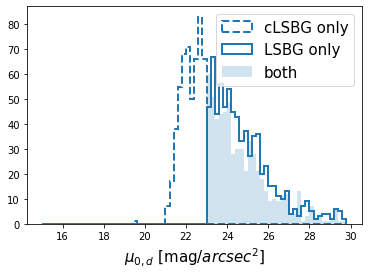

In [ ]:
plt.hist(mu0_fn[lsbconv_mask & ~lsb_mask], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG only', linestyle = '--', color ='#1f77b4')
plt.hist(mu0_fn[lsb_mask & ~lsbconv_mask], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG only', color = '#1f77b4')
plt.hist(mu0_fn[lsb_mask & lsbconv_mask], bins = np.arange(15, 30, 0.2), alpha = .2, label = 'both', color = '#1f77b4')

plt.legend(fontsize = 15)
plt.xlabel('$\mu_{0, d}$ [mag/$arcsec^{2}$]', fontsize = 15)

plt.savefig('./figs/mu_dist_both.png')

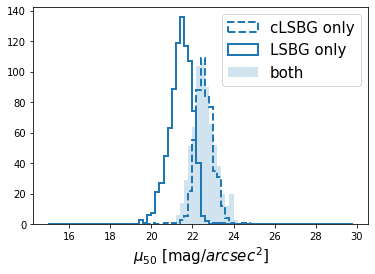

In [ ]:
plt.hist(tbl_fn[lsbconv_mask & ~lsb_mask]['mu50_g'], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG only', linestyle = '--', color ='#1f77b4')
plt.hist(tbl_fn[lsb_mask & ~lsbconv_mask]['mu50_g'], bins = np.arange(15, 30, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG only', color = '#1f77b4')
plt.hist(tbl_fn[lsb_mask & lsbconv_mask]['mu50_g'], bins = np.arange(15, 30, 0.2), alpha = .2, label = 'both', color = '#1f77b4')

plt.legend(fontsize = 15)
plt.xlabel('$\mu_{50}$ [mag/$arcsec^{2}$]', fontsize = 15)

plt.savefig('./figs/mu50_dist_both.png')

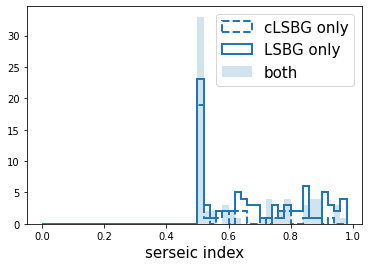

In [ ]:
plt.hist(tbl_fn[lsbconv_mask & ~lsb_mask]['n'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'cLSBG only', linestyle = '--', color ='#1f77b4')
plt.hist(tbl_fn[lsb_mask & ~lsbconv_mask]['n'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'LSBG only', color = '#1f77b4')
plt.hist(tbl_fn[lsb_mask & lsbconv_mask]['n'], bins = np.arange(0, 1, 0.02), alpha = .2, label = 'both', color = '#1f77b4')

plt.legend(fontsize = 15)
plt.xlabel('serseic index', fontsize = 15)

plt.savefig('./figs/sersic_dist_both.png')

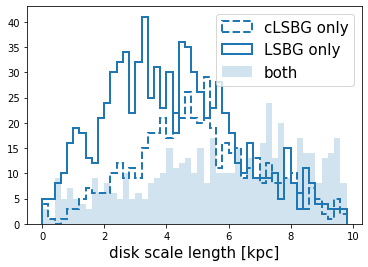

In [ ]:
plt.hist(rd_kpc[lsbconv_mask & ~lsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG only', linestyle = '--', color ='#1f77b4')
plt.hist(rd_kpc[lsb_mask & ~lsbconv_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG only', color = '#1f77b4')
plt.hist(rd_kpc[lsb_mask & lsbconv_mask], bins = np.arange(0, 10, 0.2), alpha = .2, label = 'both', color = '#1f77b4')

plt.legend(fontsize = 15)
plt.xlabel('disk scale length [kpc]', fontsize = 15)

plt.savefig('./figs/dr_dist_both.png')

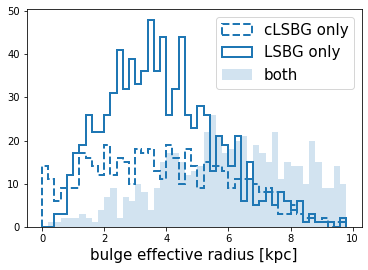

In [ ]:
plt.hist(re_kpc[lsbconv_mask & ~lsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'cLSBG only', linestyle = '--', color ='#1f77b4')
plt.hist(re_kpc[lsb_mask & ~lsbconv_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG only', color = '#1f77b4')
plt.hist(re_kpc[lsb_mask & lsbconv_mask], bins = np.arange(0, 10, 0.2), alpha = .2, label = 'both', color = '#1f77b4')

plt.legend(fontsize = 15)
plt.xlabel('bulge effective radius [kpc]', fontsize = 15)

plt.savefig('./figs/de_dist_both.png')

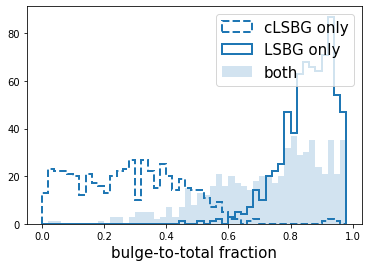

In [ ]:
plt.hist(tbl_fn[lsbconv_mask & ~lsb_mask]['bt_r'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'cLSBG only', linestyle = '--', color ='#1f77b4')
plt.hist(tbl_fn[lsb_mask & ~lsbconv_mask]['bt_r'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'LSBG only', color = '#1f77b4')
plt.hist(tbl_fn[lsb_mask & lsbconv_mask]['bt_r'], bins = np.arange(0, 1, 0.02), alpha = .2, label = 'both', color = '#1f77b4')

plt.legend(fontsize = 15)
plt.xlabel('bulge-to-total fraction', fontsize = 15)

plt.savefig('./figs/btr_dist_both.png')

## Plot density field

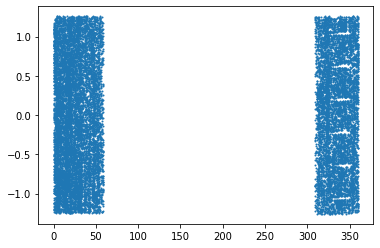

In [ ]:
plt.scatter(tbl_fn['ra'], tbl_fn['decl'], s =1)

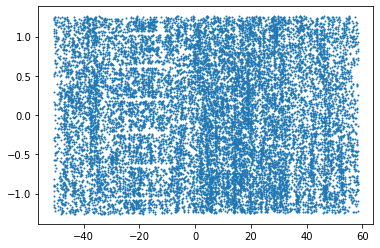

In [ ]:
ras = tbl_fn['ra']
ra_mask = tbl_fn['ra'] > 300
ras[ra_mask] = ras[ra_mask] - 360

decs = tbl_fn['decl']

plt.scatter(ras, decs, s =1)

In [ ]:
sum(tbl_fn['z'] < 0)

92

(array([3.170e+02, 1.175e+03, 2.620e+03, 2.658e+03, 2.362e+03, 2.134e+03,
        1.948e+03, 1.178e+03, 9.230e+02, 7.040e+02, 3.590e+02, 1.700e+02,
        9.800e+01, 5.300e+01, 1.400e+01, 1.100e+01, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78]),
 <BarContainer object of 39 artists>)

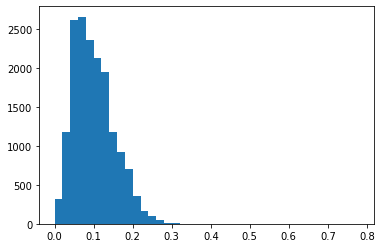

In [ ]:
plt.hist(tbl_fn['z'], np.arange(0, 0.8, 0.02))

In [ ]:
zmask = (tbl_fn['z'] < 0.15) & (tbl_fn['z'] >= 0.10)|

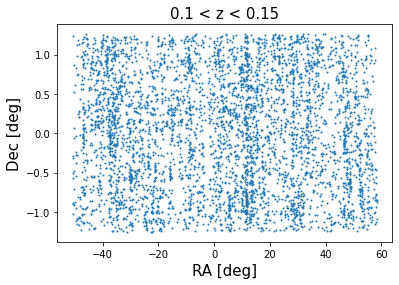

In [ ]:
plt.scatter(ras[zmask], decs[zmask], s = 1)

plt.xlabel('RA [deg]', fontsize = 15)
plt.ylabel('Dec [deg]', fontsize = 15)

plt.title('0.1 < z < 0.15', fontsize = 15)
plt.savefig('./figs/dist.png')

In [ ]:
H, xedges, yedges = np.histogram2d(ras[zmask], decs[zmask], bins = [np.arange(-50, 50, 0.5), np.arange(-1, 1, 0.05)])
H = H.T

In [ ]:
H_sm = ndimage.uniform_filter(H, size= 3)

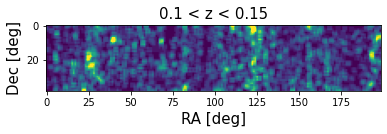

In [ ]:
fig, ax = plt.subplots()

ax.imshow(H_sm, vmin = 0, vmax = 2)
plt.xlabel('RA [deg]', fontsize = 15)
plt.ylabel('Dec [deg]', fontsize = 15)

ax.set_title('0.1 < z < 0.15', fontsize = 15)
fig.savefig('./figs/dist_density.png')

In [ ]:
np.mean(H_sm), np.std(H_sm)

(0.44362839840226775, 0.35555542439845583)

In [ ]:
np.mean(H_sm) + 3 * np.std(H_sm)

1.5102946715976353